In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io, os
import datetime
import cv2
from keras.preprocessing import image
from imagenet_utils import preprocess_input
from scipy import misc

Using TensorFlow backend.


In [2]:
# matalb cmd 창에서 실행
# /usr/local/MATLAB/R2016b/bin/.matlab -nojvm < generate_lap.m

# CONSTANT

In [3]:
# IMAGE
IMAGE_W = 400
IMAGE_H = 400

NOISE_IMG = np.random.uniform(-20, 20 ,(1, IMAGE_H, IMAGE_W,3 )).astype('float32')

CONT_NAME = 'in16.png'
STY_NAME = 'tar16.png'
IN_SEG_NMAE = 'in16_seg.png'
TAR_SEG_NMAE = 'tar16_seg.png'

c_ind = {(0, 255, 0):0, #green
            (0, 0, 0):1, #black
             (255, 255, 255):2} #white

# read laplacian matrix

In [8]:
l_csc = scipy.io.loadmat('in16matt_csc.mat')

In [9]:
print(l_csc['CSC'].shape)

(3976036, 3)


In [10]:
L = l_csc['CSC']
L = np.array([ [r-1, c-1, v] for  r,c,v in L])
print(L[:3,:], type(L))

[[ 0.          0.          0.88888889]
 [ 1.          0.         -0.11111111]
 [ 2.          0.         -0.11111111]] <class 'numpy.ndarray'>


In [11]:
inds = np.array(list(zip(L[:,0].astype(int), L[:,1].astype(int))))
values = np.array(L[:,2])
values = values.astype(np.float32)

In [12]:
matt = tf.SparseTensor(indices=inds, values=values,dense_shape=[IMAGE_H*IMAGE_W, IMAGE_H*IMAGE_W])

In [13]:
del(inds, values,L, l_csc)

# Neural Network

### funcs

In [14]:
# for image process
def read_image_file(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_H,IMAGE_W))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

def reverse_preprocess(x):
    x[:, :, :, 0] += 103.939
    x[:, :, :, 1] += 116.779
    x[:, :, :, 2] += 123.68    
    return x[:, :, :, ::-1]

def visualize_img(x):
    return np.clip(x, 0, 255).astype('uint8')

In [15]:
def conv2d(x, W):
    return tf.nn.conv2d(x,W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')

In [16]:
def make_mask(img):
    mask = np.zeros([img.shape[0], img.shape[1], len(c_ind)])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            r,g,b = img[i,j,:]
            try:
                ind = c_ind[(r,g,b)]
            except:
                ind = 2 # defalut white
            mask[i,j,ind] = 1
    return mask

In [17]:
def mask_flatten(mlist):
    for i in range(len(mlist)):
        mask = mlist[i]
        h,w,c = mask.shape
        mlist[i] = np.reshape(mask, (h*w,c))

## segmentation mask image load and make mask

In [18]:
inp_seg = cv2.imread(IN_SEG_NMAE)
inp_seg = cv2.resize(inp_seg,(IMAGE_H, IMAGE_W))
_, inp_seg = cv2.threshold(inp_seg, 200, 255, cv2.THRESH_BINARY)

In [19]:
tar_seg = cv2.imread(TAR_SEG_NMAE)
tar_seg = cv2.resize(tar_seg, (IMAGE_H, IMAGE_W))
_, tar_seg = cv2.threshold(tar_seg, 200, 255, cv2.THRESH_BINARY)

In [20]:
inp_mask = make_mask(inp_seg)
tar_mask = make_mask(tar_seg)

In [21]:
inp_mask_list = [inp_mask, 
                 cv2.resize(inp_mask, (int(IMAGE_H/2), int(IMAGE_W/2))),
                cv2.resize(inp_mask, (int(IMAGE_H/4), int(IMAGE_W/4))),
                cv2.resize(inp_mask, (int(IMAGE_H/8), int(IMAGE_W/8))),
                cv2.resize(inp_mask, (int(IMAGE_H/16), int(IMAGE_W/16))),]

In [22]:
mask_flatten(inp_mask_list)

In [23]:
tar_mask_list = [tar_mask, 
                 cv2.resize(tar_mask, (int(IMAGE_H/2), int(IMAGE_W/2))),
                cv2.resize(tar_mask, (int(IMAGE_H/4), int(IMAGE_W/4))),
                cv2.resize(tar_mask, (int(IMAGE_H/8), int(IMAGE_W/8))),
                cv2.resize(tar_mask, (int(IMAGE_H/16), int(IMAGE_W/16))),]

In [24]:
mask_flatten(tar_mask_list)

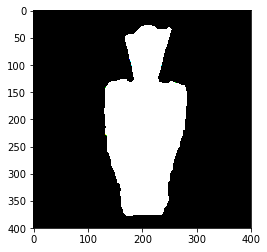

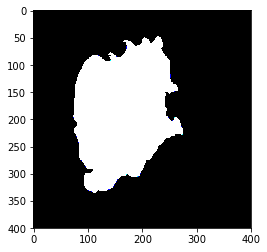

In [25]:
plt.imshow(inp_seg)
plt.show()
plt.imshow(tar_seg)
plt.show()

## network

In [26]:
vggW = np.load('vgg_weight.npy')

In [27]:
# vgg19 network with weights(constant)

W_CONV1_1 = tf.constant(vggW[0])
b_CONV1_1 = tf.constant(vggW[1])
W_CONV1_2 = tf.constant(vggW[2])
b_CONV1_2 = tf.constant(vggW[3])

W_CONV2_1 = tf.constant(vggW[4])
b_CONV2_1 = tf.constant(vggW[5])
W_CONV2_2 = tf.constant(vggW[6])
b_CONV2_2 = tf.constant(vggW[7])

W_CONV3_1 = tf.constant(vggW[8])
b_CONV3_1 = tf.constant(vggW[9])
W_CONV3_2 = tf.constant(vggW[10])
b_CONV3_2 = tf.constant(vggW[11])
W_CONV3_3 = tf.constant(vggW[12])
b_CONV3_3 = tf.constant(vggW[13])
W_CONV3_4 = tf.constant(vggW[14])
b_CONV3_4 = tf.constant(vggW[15])

W_CONV4_1 = tf.constant(vggW[16])
b_CONV4_1 = tf.constant(vggW[17])
W_CONV4_2 = tf.constant(vggW[18])
b_CONV4_2 = tf.constant(vggW[19])
W_CONV4_3 = tf.constant(vggW[20])
b_CONV4_3 = tf.constant(vggW[21])
W_CONV4_4 = tf.constant(vggW[22])
b_CONV4_4 = tf.constant(vggW[23])

W_CONV5_1 = tf.constant(vggW[24])
b_CONV5_1 = tf.constant(vggW[25])

del(vggW)

In [28]:
x = tf.Variable(tf.random_uniform(shape=(1,IMAGE_H, IMAGE_W, 3), minval= 0,maxval=255))

In [29]:
h_conv1_1 = tf.nn.relu(conv2d(x,         W_CONV1_1) + b_CONV1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, W_CONV1_2) + b_CONV1_2)
h_pool1 = avg_pool_2x2(h_conv1_2)

h_conv2_1 = tf.nn.relu(conv2d(h_pool1,   W_CONV2_1) + b_CONV2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, W_CONV2_2) + b_CONV2_2)
h_pool2 = avg_pool_2x2(h_conv2_2)

h_conv3_1 = tf.nn.relu(conv2d(h_pool2,   W_CONV3_1) + b_CONV3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, W_CONV3_2) + b_CONV3_2)
h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, W_CONV3_3) + b_CONV3_3)
h_conv3_4 = tf.nn.relu(conv2d(h_conv3_3, W_CONV3_4) + b_CONV3_4)
h_pool3 = avg_pool_2x2(h_conv3_4)

h_conv4_1 = tf.nn.relu(conv2d(h_pool3,   W_CONV4_1) + b_CONV4_1)
h_conv4_2 = tf.nn.relu(conv2d(h_conv4_1, W_CONV4_2) + b_CONV4_2)
h_conv4_3 = tf.nn.relu(conv2d(h_conv4_2, W_CONV4_3) + b_CONV4_3)
h_conv4_4 = tf.nn.relu(conv2d(h_conv4_3, W_CONV4_4) + b_CONV4_4)
h_pool4 = avg_pool_2x2(h_conv4_4)

h_conv5_1 = tf.nn.relu(conv2d(h_pool4, W_CONV5_1) + b_CONV5_1)

In [30]:
# feature map

# for style
F1 = tf.reshape(h_conv1_1, [ IMAGE_H * IMAGE_W, 64])
F2 = tf.reshape(h_conv2_1, [ int(IMAGE_H/2 * IMAGE_W/2), 128])
F3 = tf.reshape(h_conv3_1, [ int(IMAGE_H/4 * IMAGE_W/4), 256])
F4 = tf.reshape(h_conv4_1, [ int(IMAGE_H/8 * IMAGE_W/8), 512])
F5 = tf.reshape(h_conv5_1, [ int(IMAGE_H/16 * IMAGE_W/16), 512])

# for content
F4_2 = tf.reshape(h_conv4_2, [ int(IMAGE_H/8 * IMAGE_W/8), 512])

# F4_2 = tf.reshape(h_conv2_2, [ int(IMAGE_H/2 * IMAGE_W/2), 128])

## content image

In [31]:
cont_img = read_image_file(CONT_NAME)

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(x.assign(cont_img))
    cont_F4_2 = sess.run(F4_2)
    

## style image

In [33]:
mask_list = tar_mask_list

M1 = tf.constant(mask_list[0],dtype=tf.float32)
M2 = tf.constant(mask_list[1],dtype=tf.float32)
M3 = tf.constant(mask_list[2],dtype=tf.float32)
M4 = tf.constant(mask_list[3],dtype=tf.float32)
M5 = tf.constant(mask_list[4],dtype=tf.float32)

# modified style loss
F1_ = tf.reshape(F1[:,tf.newaxis,:]*M1[...,tf.newaxis],[(IMAGE_H*IMAGE_W) ,-1])
F2_ = tf.reshape(F2[:,tf.newaxis,:]*M2[...,tf.newaxis],[int(IMAGE_H/2 * IMAGE_W/2) ,-1])
F3_ = tf.reshape(F3[:,tf.newaxis,:]*M3[...,tf.newaxis],[int(IMAGE_H/4 * IMAGE_W/4) ,-1])
F4_ = tf.reshape(F4[:,tf.newaxis,:]*M4[...,tf.newaxis],[int(IMAGE_H/8 * IMAGE_W/8) ,-1])
F5_ = tf.reshape(F5[:,tf.newaxis,:]*M5[...,tf.newaxis],[int(IMAGE_H/16 * IMAGE_W/16) ,-1])

# modified gramm matrix
G1 = tf.matmul(tf.transpose(F1_), F1_)
G2 = tf.matmul(tf.transpose(F2_), F2_)
G3 = tf.matmul(tf.transpose(F3_), F3_)
G4 = tf.matmul(tf.transpose(F4_), F4_)
G5 = tf.matmul(tf.transpose(F5_), F5_)

In [34]:
sty_img = read_image_file(STY_NAME)

In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(x.assign(sty_img))
    styAlist = sess.run([G1, G2, G3, G4, G5])

## transferring

#### make phtorealism regularization loss term

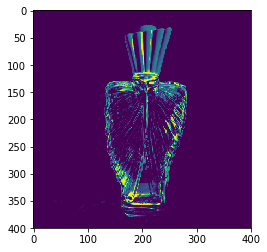

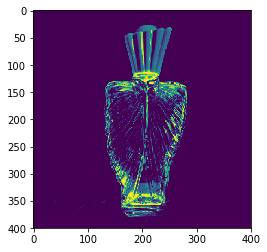

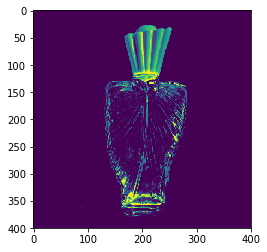

In [36]:
# regularization loss term 추가
x_ = tf.squeeze(x) # 1,224,224,3 --> 224, 224, 3
x1 = tf.slice(x_,[0,0,0],[IMAGE_H,IMAGE_W,1])
x2 = tf.slice(x_,[0,0,1],[IMAGE_H,IMAGE_W,1])
x3 = tf.slice(x_,[0,0,2],[IMAGE_H,IMAGE_W,1])


# get images per channel
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(x.assign(cont_img))

    temp1 = sess.run(x1)
    temp1 = np.squeeze(temp1)
    plt.imshow(temp1)
    plt.show()
    
    temp2 = sess.run(x2)
    temp2 = np.squeeze(temp2)
    plt.imshow(temp2)
    plt.show()
    
    temp3 = sess.run(x3)
    temp3 = np.squeeze(temp3)
    plt.imshow(temp3)
    plt.show()

In [37]:
# regularization loss
x1 = tf.transpose(x1)
Lm1 = tf.sparse_tensor_dense_matmul(matt, tf.reshape(x1, [IMAGE_H*IMAGE_W,1]))
Lm1 = tf.matmul(tf.reshape(x1,[1,IMAGE_H*IMAGE_W]), Lm1)

x2 = tf.transpose(x2)
Lm2 = tf.sparse_tensor_dense_matmul(matt, tf.reshape(x2, [IMAGE_H*IMAGE_W,1]))
Lm2 = tf.matmul(tf.reshape(x2,[1,IMAGE_H*IMAGE_W]), Lm2)

x3 = tf.transpose(x3)
Lm3 = tf.sparse_tensor_dense_matmul(matt, tf.reshape(x3, [IMAGE_H*IMAGE_W,1]))
Lm3 = tf.matmul(tf.reshape(x3,[1,IMAGE_H*IMAGE_W]), Lm3)

reg_loss = Lm1 + Lm2 + Lm3

# mask change

In [38]:
# mask change 
mask_list = inp_mask_list

M1 = tf.constant(mask_list[0],dtype=tf.float32)
M2 = tf.constant(mask_list[1],dtype=tf.float32)
M3 = tf.constant(mask_list[2],dtype=tf.float32)
M4 = tf.constant(mask_list[3],dtype=tf.float32)
M5 = tf.constant(mask_list[4],dtype=tf.float32)

# modified style loss
F1_ = tf.reshape(F1[:,tf.newaxis,:]*M1[...,tf.newaxis],[(IMAGE_H*IMAGE_W) ,-1])
F2_ = tf.reshape(F2[:,tf.newaxis,:]*M2[...,tf.newaxis],[int(IMAGE_H/2 * IMAGE_W/2) ,-1])
F3_ = tf.reshape(F3[:,tf.newaxis,:]*M3[...,tf.newaxis],[int(IMAGE_H/4 * IMAGE_W/4) ,-1])
F4_ = tf.reshape(F4[:,tf.newaxis,:]*M4[...,tf.newaxis],[int(IMAGE_H/8 * IMAGE_W/8) ,-1])
F5_ = tf.reshape(F5[:,tf.newaxis,:]*M5[...,tf.newaxis],[int(IMAGE_H/16 * IMAGE_W/16) ,-1])

# modified gramm matrix
G1 = tf.matmul(tf.transpose(F1_), F1_)
G2 = tf.matmul(tf.transpose(F2_), F2_)
G3 = tf.matmul(tf.transpose(F3_), F3_)
G4 = tf.matmul(tf.transpose(F4_), F4_)
G5 = tf.matmul(tf.transpose(F5_), F5_)

In [39]:
# training hyperparameters
ALPHA = 1   
BETA = 1            
GAMMA = 100     
EW = [0.2, 0.2, 0.2, 0.2, 0.2]
LAMBDA = 10^8
LEARNING_RATE = 0.5

DELTA = 0.01

In [40]:
# content loss
cont_loss = tf.reduce_sum(tf.pow(F4_2 - cont_F4_2, 2)) /( 2*(IMAGE_H/8) * (IMAGE_W/8) * 512 )

# modified style loss
E1 = tf.reduce_sum(tf.pow(G1 - styAlist[0], 2))
E2 = tf.reduce_sum(tf.pow(G2 - styAlist[1], 2))
E3 = tf.reduce_sum(tf.pow(G3 - styAlist[2], 2))
E4 = tf.reduce_sum(tf.pow(G4 - styAlist[3], 2))
E5 = tf.reduce_sum(tf.pow(G5 - styAlist[4], 2))

sty_loss = EW[0] * E1 /(2*(64*3)**2) \
            +EW[1] * E2 /(2*(128*3)**2) \
            +EW[2] * E3 /(2*(256*3)**2) \
            +EW[3] * E4 /(2*(512*3)**2) \
            +EW[4] * E5 /(2*(512*3)**2)          

# tv loss
tv_loss = tf.reduce_sum(tf.image.total_variation(x))

# 2 step optimizations
loss1 = ALPHA*cont_loss + GAMMA*BETA*sty_loss 

loss2 =  LAMBDA*reg_loss + DELTA*tv_loss


train_op1 = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss1)

train_op2 = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss2)


## 결과 이미지 저장할 dir 설정

In [41]:
now = datetime.datetime.now()
DIR_NAME = now.strftime('%m_%d_%H_%M')
print(DIR_NAME)
if not os.path.exists(DIR_NAME):
    os.makedirs(DIR_NAME)

07_13_14_44


## transfer

step : 0, loss : 1.31084e+17
style loss : 1.31084e+15, content loss : 0


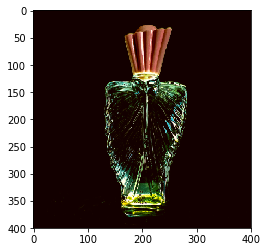

step : 1000, loss : 2.63983e+14
style loss : 2.63983e+12, content loss : 25296


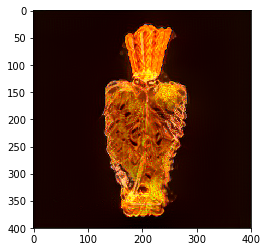

step : 0, loss : 6.37367e+08
reg loss : 3.18649e+08, tv loss : 6.8829e+06


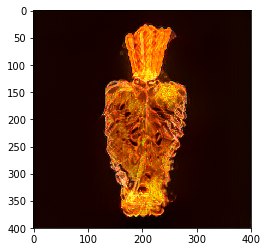

step : 1000, loss : 900357
reg loss : 436827, tv loss : 2.67033e+06


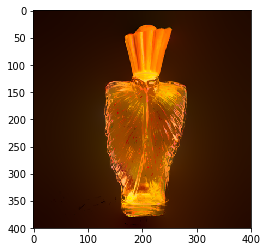

step : 2000, loss : 298973
reg loss : 136216, tv loss : 2.65416e+06


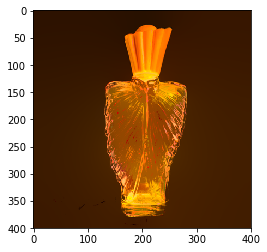

step : 0, loss : 8.98763e+16
style loss : 8.98764e+14, content loss : 14602.2


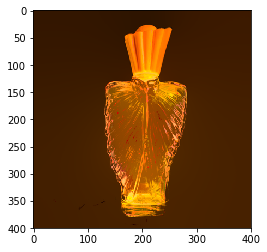

step : 1000, loss : 9.95531e+13
style loss : 9.95531e+11, content loss : 25769.5


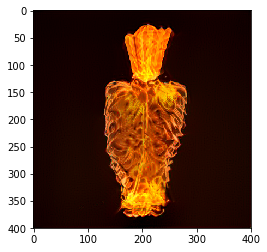

step : 0, loss : 2.3412e+08
reg loss : 1.17035e+08, tv loss : 4.98454e+06


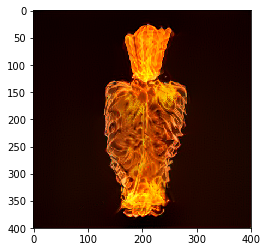

step : 1000, loss : 363093
reg loss : 167673, tv loss : 2.77474e+06


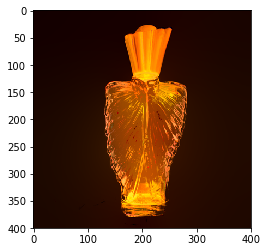

step : 2000, loss : 232170
reg loss : 102044, tv loss : 2.80818e+06


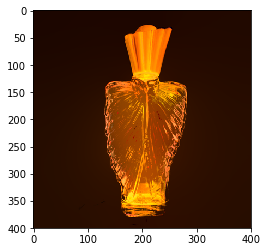

step : 0, loss : 3.20935e+16
style loss : 3.20935e+14, content loss : 13236.8


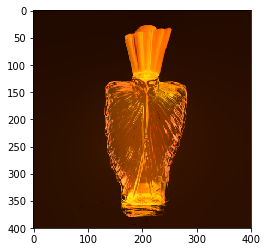

step : 1000, loss : 7.20139e+13
style loss : 7.20139e+11, content loss : 26267.4


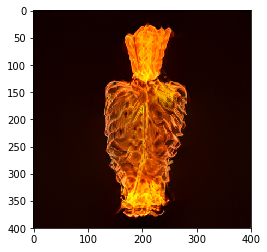

step : 0, loss : 2.34121e+08
reg loss : 1.17037e+08, tv loss : 4.61591e+06


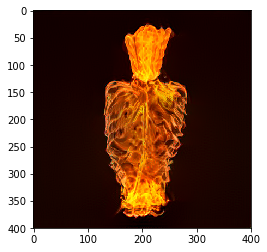

step : 1000, loss : 283544
reg loss : 128016, tv loss : 2.75115e+06


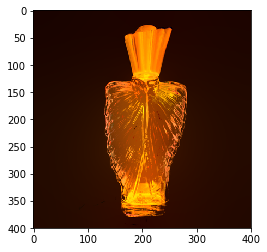

step : 2000, loss : 184978
reg loss : 78548.7, tv loss : 2.78807e+06


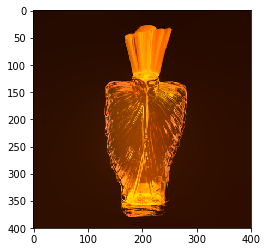

In [42]:

# loss info write in txt file
f=  open(DIR_NAME+'/parameters.txt','w')
f.write('ALAPHA :%g, BETA : %g, GAMMA : %g, LAMBDA : %g, Learning Rate : %g '%(ALPHA, BETA, GAMMA, LAMBDA,LEARNING_RATE) )

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     inp = np.random.uniform(-20, 20 ,(1, IMAGE_H, IMAGE_W,3 )).astype('float32')
    sess.run(x.assign(cont_img))
    for j in range(3):
        for i in range(1501):
            if i %500 ==0:

                # write loss log
                _loss1, _styloss, _contloss, temp = sess.run([loss1, sty_loss, cont_loss, x])
                f.write('\nstep : %d, loss : %d, style loss :%g, content loss : %g'%(i, _loss1, _styloss, _contloss))

                # save result image
                temp = reverse_preprocess(temp)
                temp = np.squeeze(temp,axis=0)
                temp = visualize_img(temp)
                misc.imsave(DIR_NAME+'/'+str(j)+'_1_'+str(i)+'th_mixed_image.jpg',temp)

                #show result image
                if i % 1000 == 0 :
                    print('step : %d, loss : %g'%(i, _loss1))
                    print('style loss : %g, content loss : %g'%(_styloss, _contloss))
                    plt.imshow(temp)
                    plt.show()
            # training
            sess.run(train_op1)

        for k in range(2501):
            if k %500 ==0:

                # write loss log
                _loss2, _regloss, _tvloss, temp = sess.run([loss2, reg_loss, tv_loss, x])
                f.write('\nstep : %d, loss : %d, reg loss :%g, tv loss : %g'%(k, _loss2, _styloss, _contloss))

                # save result image
                temp = reverse_preprocess(temp)
                temp = np.squeeze(temp,axis=0)
                temp = visualize_img(temp)
                misc.imsave(DIR_NAME+'/'+str(j)+'_2_'+str(k)+'th_mixed_image.jpg',temp)

                #show result image
                if k % 1000 == 0 :
                    print('step : %d, loss : %g'%(k, _loss2))
                    print('reg loss : %g, tv loss : %g'%(_regloss,_tvloss))
                    plt.imshow(temp)
                    plt.show()
            # training
            sess.run(train_op2)


# loss file close
f.close()